In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from torchvision import transforms, datasets, models
from torch.amp import autocast, GradScaler
from trainning.fusion_dataset import FusionDataset
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL, UNet2DConditionModel, DPMSolverMultistepScheduler

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNNBranch(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, feature_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class TransformerBranch(nn.Module):
    def __init__(self, feature_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)  # [B,HW,C]
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        return x


class HybridEncoder(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.feature_dim = feature_dim
        self.content_cnn = CNNBranch(in_channels, feature_dim)
        self.style_cnn   = CNNBranch(in_channels, feature_dim)
        self.transformer = TransformerBranch(feature_dim=feature_dim)
        self.fuse_conv   = nn.Conv2d(2*feature_dim, feature_dim, 1)

    def forward(self, img1, img2):
        feat_c = self.content_cnn(img1)   # Content features
        feat_s = self.style_cnn(img2)     # Style features

        fused = torch.cat([feat_c, feat_s], dim=1)   # concat along channels
        fused = self.fuse_conv(fused)                # fuse
        global_context = self.transformer(fused)
        return global_context
    

class FusionSDTurboModel(nn.Module):
    def __init__(self, encoder: nn.Module,
                 pretrained_model="stabilityai/sd-turbo",
                 device="cuda"):
        super().__init__()
        self.device = device
        self.encoder = encoder

        # Load pretrained SD-Turbo components
        self.vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae").to(device)
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet").to(device)

        # Enable gradient checkpointing for UNet
        self.unet.enable_gradient_checkpointing()

        # Recommended SD scheduler
        self.scheduler = DPMSolverMultistepScheduler.from_pretrained(pretrained_model, subfolder="scheduler")

        # Cross-attention projection
        cross_dim = self.unet.config.cross_attention_dim
        self.proj = nn.Linear(encoder.feature_dim, cross_dim)

        # Resize inputs to 256x256
        self.upsample = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC)

        # Latent scaling factor
        self.latent_scale = self.vae.config.scaling_factor

    def encode_latents(self, x):
        latents = self.vae.encode(x).latent_dist.sample()
        return latents * self.latent_scale

    def decode_latents(self, latents):
        latents = latents / self.latent_scale
        imgs = self.vae.decode(latents).sample
        return imgs

    def forward(self, img1, img2, timesteps):
        # Upsample to 256x256
        img1 = self.upsample(img1)
        img2 = self.upsample(img2)

        # Mixed precision context
        with torch.amp.autocast(device_type=self.device, dtype=torch.float16):
            # Encode & fuse
            fused_feats = self.encoder(img1, img2)
            pooled = fused_feats.flatten(2).transpose(1, 2)   # [B,HW,C]
            cond = self.proj(pooled)                          # [B,HW,cross_dim]

            # Encode target to latent (img1)
            latents = self.encode_latents(img1)

            # Add noise
            noise = torch.randn_like(latents)
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

            # Predict noise
            noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states=cond).sample

            # Reconstruct image
            denoised_latents = latents - noise_pred
            out = self.decode_latents(denoised_latents)

        return noise_pred, noise, out

In [3]:
# VGG Feature Extractor (for content + style)
class VGGFeatureExtractor(nn.Module):
    def __init__(self, layers=[3, 8]):  # conv1_2, conv2_2
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = layers
        self.slices = nn.ModuleList()
        prev = 0
        for l in layers:
            block = nn.Sequential(*list(vgg.children())[prev:l+1])
            self.slices.append(block)
            prev = l+1
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        feats = []
        for block in self.slices:
            x = block(x)
            feats.append(x)
        return feats
    
def gram_matrix(feat):
    B, C, H, W = feat.size()
    feat = feat.view(B, C, H*W)
    G = torch.bmm(feat, feat.transpose(1, 2))
    return G.div(C * H * W).clamp(min=-1e4, max=1e4)

In [4]:
def freeze_module(module):
    """Utility: Freeze all params in a module"""
    for p in module.parameters():
        p.requires_grad = False

def train(model, dataloader, extractor, device="cuda", epochs=10, lr=2e-5):
    model.to(device)

    # Freeze VAE + UNet
    freeze_module(model.vae)
    freeze_module(model.unet)

    # Optimizer → only train encoder + projection
    opt = torch.optim.AdamW(list(model.encoder.parameters()) + list(model.proj.parameters()), lr=lr)
    scaler = GradScaler(device) 

    for epoch in range(epochs):
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for img1, img2 in pbar:
            img1, img2 = img1.to(device), img2.to(device)

            timesteps = torch.randint(
                0, model.scheduler.num_train_timesteps, (img1.size(0),), device=device, dtype=torch.long
            )

            # Mixed precision forward
            with autocast(device, dtype=torch.float16):
                noise_pred, noise, out = model(img1, img2, timesteps)
            
            # Noise prediction (diffusion training objective)
            L_noise = F.mse_loss(noise_pred.float(), noise.float())

            # Style loss (borrow texture from img2)
            feats_out = extractor(out.float())
            feats_style = extractor(img2.float())

            L_style = 0
            for f_out, f_style in zip(feats_out, feats_style):
                G_out = gram_matrix(f_out)
                G_style = gram_matrix(f_style)
                L_style += F.mse_loss(G_out, G_style)

            # Final loss
            loss = L_noise + 1.0 * L_style

            # Backward + optimizer step
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            pbar.set_postfix({"loss": loss.item()})
            torch.save(model.state_dict(), f"checkpoint/FusionSDTurboModel_v2_{epoch+1}.pt")

In [5]:
def show_test_results(model, dataloader, device="cuda", num_images=5, num_inference_steps=50):
    model.eval()
    model.to(device)

    img1, img2 = next(iter(dataloader))
    img1, img2 = img1[:num_images], img2[:num_images]
    img1, img2 = img1.to(device), img2.to(device)

    with torch.no_grad():
        # --- Conditioning ---
        fused_feats = model.encoder(img1, img2)
        pooled = fused_feats.flatten(2).transpose(1, 2)   # [B,HW,C]
        cond = model.proj(pooled)                         # [B,HW,cross_dim]

        # --- Random latent init ---
        latent_shape = (img1.size(0), model.unet.in_channels, 32, 32) # 256x256 → 32x32
        latents = torch.randn(latent_shape, device=device)

        # --- Denoising loop ---
        scheduler = model.scheduler
        scheduler.set_timesteps(num_inference_steps, device=device)
        for t in scheduler.timesteps:
            noise_pred = model.unet(latents, t, encoder_hidden_states=cond).sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        # --- Decode latents ---
        pred_imgs = model.decode_latents(latents)


    # Simple denormalization from [-1, 1] → [0, 1]
    def denorm(x):
        return (x.clamp(-1, 1) + 1) / 2

    # Display input, target, and prediction
    for i in range(num_images):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(denorm(img1[i]).permute(1, 2, 0).cpu())
        axes[0].set_title("Input 1")
        axes[1].imshow(denorm(img2[i]).permute(1, 2, 0).cpu())
        axes[1].set_title("Input 2")
        axes[2].imshow(denorm(pred_imgs[i]).permute(1, 2, 0).cpu())
        axes[2].set_title("Generated")
        for ax in axes:
            ax.axis("off")
        plt.show()

In [6]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

base_dataset = datasets.ImageFolder(root="data/afhq/train", transform=None)

# Use a subset for quick testing
subset_indices = np.random.choice(len(base_dataset), 1000, replace=False)
small_dataset = Subset(base_dataset, subset_indices)

fusion_dataset = FusionDataset(small_dataset, transform=transform)
fusion_loader = DataLoader(fusion_dataset, batch_size=5, shuffle=True, num_workers=6, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# instantiate encoder and pipeline model
encoder = HybridEncoder(in_channels=3, feature_dim=128)
model = FusionSDTurboModel(encoder=encoder, pretrained_model="stabilityai/sd-turbo", device=device)
vgg_extractor = VGGFeatureExtractor(layers=[3, 8]).to(device)

Using device: cuda


c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
train(model, dataloader=fusion_loader, extractor=vgg_extractor,device=device, epochs=3, lr=2e-5)

Epoch 1/3:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DPMSolverMultistepScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DPMSolverMultistepScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 2/3:  76%|███████▋  | 153/200 [2:46:44<51:13, 65.39s/it, loss=0.115]   


KeyboardInterrupt: 

In [ ]:
# # Free memory
# import torch
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

C:\Users\HanDong\AppData\Local\Temp\ipykernel_7684\1240695485.py:16: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latent_shape = (img1.size(0), model.unet.in_channels, 32, 32) # 256x256 → 32x32


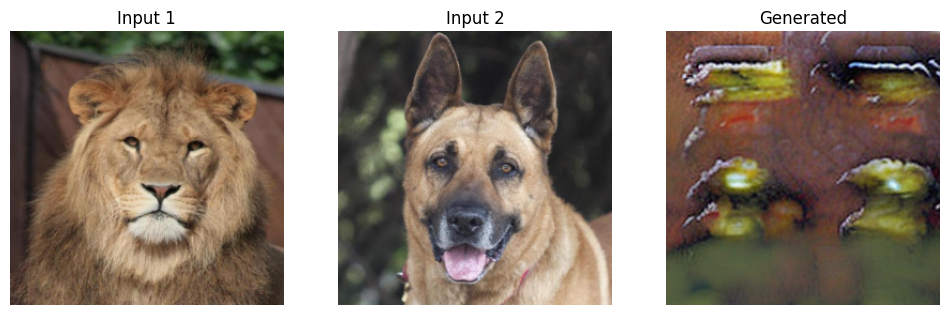

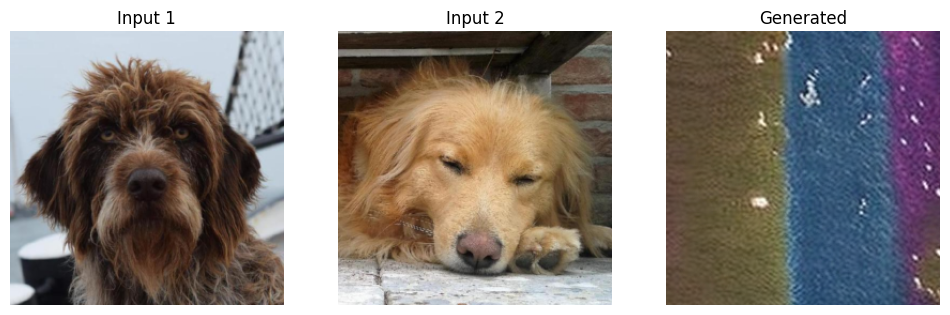

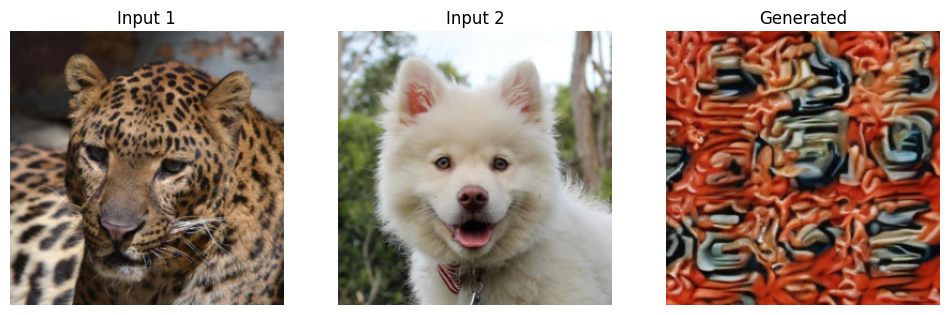

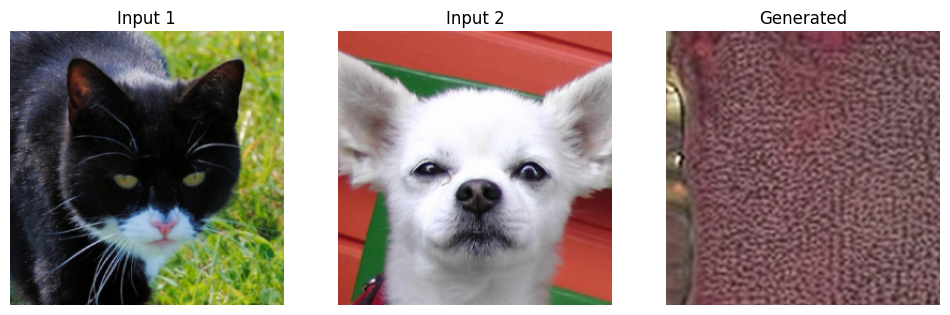

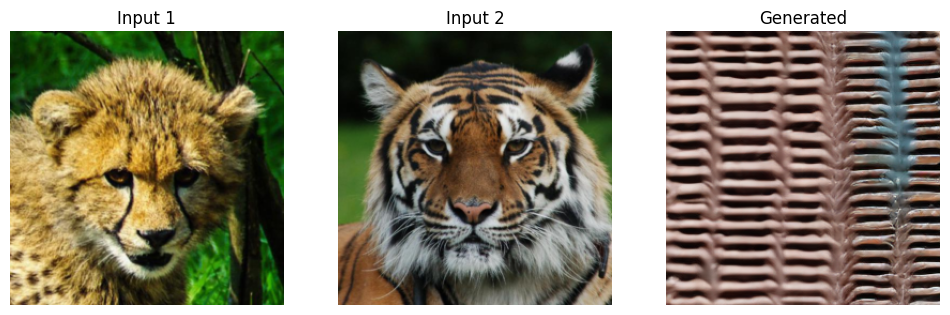

In [9]:
show_test_results(model, fusion_loader, device=device, num_images=5, num_inference_steps=50)